In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
transform = transforms.ToTensor()

In [9]:
mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
fashion_train = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
fashion_test = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)


In [11]:
train_size = int(0.9 * len(mnist_train))
val_size = len(mnist_train) - train_size
mnist_train, mnist_val = random_split(mnist_train, [train_size, val_size])

In [13]:
batch_size = 64

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [15]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 1 input channel → 32 output channels
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 32 → 64 output channels
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # Reduce size by half
            nn.Dropout(0.25)                            # Dropout after conv block
        )
        
        self.fc = nn.Sequential(
            nn.Flatten(),                               # Flatten for fully connected layer
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(),
            nn.Dropout(0.5),                            # Dropout after first FC layer
            nn.Linear(128, 10)                          # Output 10 classes
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [17]:
model = CustomCNN().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
train_losses = []
val_accuracies = []

In [23]:
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Validate the model after each epoch
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = correct / total
    
    # Record training loss and validation accuracy
    train_losses.append(running_loss / len(train_loader))
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Accuracy: {val_acc:.4f}")


Epoch [1/30], Loss: 0.2534, Val Accuracy: 0.9807
Epoch [2/30], Loss: 0.0976, Val Accuracy: 0.9833
Epoch [3/30], Loss: 0.0720, Val Accuracy: 0.9852
Epoch [4/30], Loss: 0.0623, Val Accuracy: 0.9883
Epoch [5/30], Loss: 0.0495, Val Accuracy: 0.9877
Epoch [6/30], Loss: 0.0458, Val Accuracy: 0.9890
Epoch [7/30], Loss: 0.0373, Val Accuracy: 0.9885
Epoch [8/30], Loss: 0.0383, Val Accuracy: 0.9893
Epoch [9/30], Loss: 0.0315, Val Accuracy: 0.9892
Epoch [10/30], Loss: 0.0290, Val Accuracy: 0.9880
Epoch [11/30], Loss: 0.0265, Val Accuracy: 0.9893
Epoch [12/30], Loss: 0.0262, Val Accuracy: 0.9898
Epoch [13/30], Loss: 0.0225, Val Accuracy: 0.9902
Epoch [14/30], Loss: 0.0215, Val Accuracy: 0.9895
Epoch [15/30], Loss: 0.0201, Val Accuracy: 0.9880
Epoch [16/30], Loss: 0.0192, Val Accuracy: 0.9890
Epoch [17/30], Loss: 0.0179, Val Accuracy: 0.9900
Epoch [18/30], Loss: 0.0180, Val Accuracy: 0.9908
Epoch [19/30], Loss: 0.0169, Val Accuracy: 0.9902
Epoch [20/30], Loss: 0.0137, Val Accuracy: 0.9902
Epoch [21

In [24]:
torch.save(model.state_dict(), 'customcnn_mnist.pth')

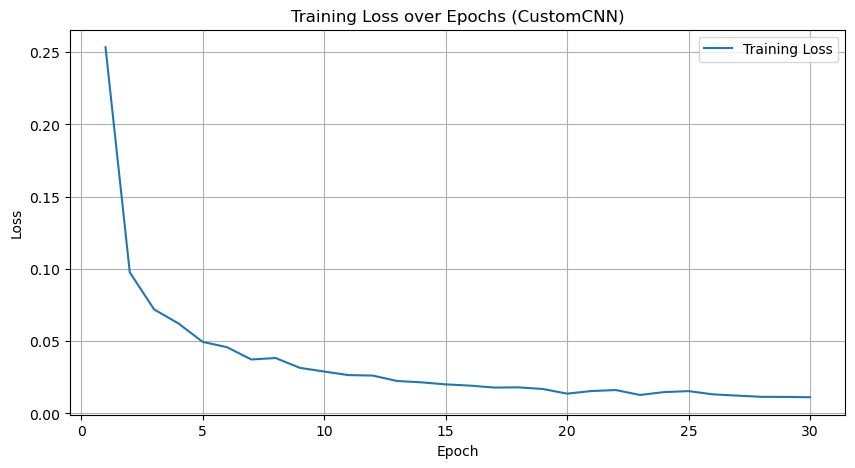

In [25]:
plt.figure(figsize=(10,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs (CustomCNN)')
plt.legend()
plt.grid(True)
plt.show()

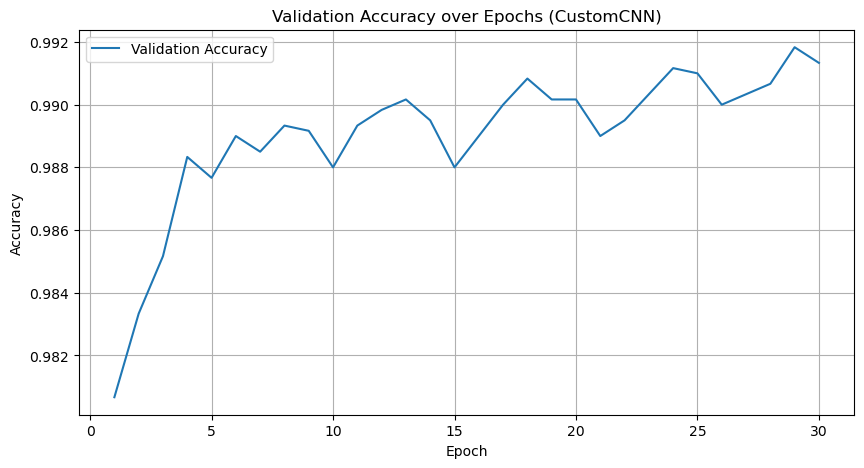

In [26]:
plt.figure(figsize=(10,5))
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs (CustomCNN)')
plt.legend()
plt.grid(True)
plt.show()